V:2021/10/08

# Elimination of the anthropogenic noise: `antropo`

The code shown is this notebook is aimed at removing the anthropogenic signals detected in the measurements recorded at the station. The anthropogenic noise appears as narrow peaks in the signal spectrum. These signals appear mainly in three bands: {14.7,15.00}, {15.00,15.48}, {16.45,16.90} Hz.

The analysis of the anthropogenic signal requires a detailed visual analysis of the signal. That is why we have chosen to use a Jupyter notebook that allows to view the measurements quickly and comfortably.

## Packages and inputs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
%matplotlib inline

In [2]:
# INPUTS
year="2015"
month="1503"
pathg='S_N_DF/'           # Have to be specified        

We define the year and month of data. Next we define the path where the file with the FFT of the measurements of the month is located.

## Internal values

In [3]:
divi=6
nventa=2**13
fm=256
nintervdia=divi*24
df=float(fm)/float(nventa)
bandcal=np.array([6,25],dtype=float)
nhora=fm*3600
fre=np.arange(bandcal[0],bandcal[1]+df,df)
nf=len(fre)
def pofre(f,df,fi):
    return int(round((f-fi)/df))

See the notebook `Reading_Fourier_docu` for the meaning of theese parameters.

The function `pofre(f,df,fi)` determines the position of a frequency `f` in a list of frequencies with a starting frequency, `fi`, and a frequency increment `df`.

## Reading spectra

In [6]:
pathmes=pathg+year+"/"+month+"/"+"SR"+month[0:4]+"_"

fichmedia0=pathmes+"media"+"_0"
fichmedia1=pathmes+"media"+"_1"

fichsatper0=pathmes+"satper"+"_0"
fichsatper1=pathmes+"satper"+"_1"                               
                               
medidas0=np.genfromtxt(fichmedia0).reshape(-1,nf)
medidas1=np.genfromtxt(fichmedia1).reshape(-1,nf)
satper0=np.genfromtxt(fichsatper0)
satper1=np.genfromtxt(fichsatper1)
nhoras=len(medidas0)//divi
ndias=nhoras//24

We read the spectra corresponding to the band 6-25 Hz, which corresponds to the calibration band of the magnetometers.
We recall that we work with intervals of 10 min. In each interval we have the spectrum with a number of samples defined by the calibration bandwidth and the increment in frequencies, $df$.
The path is stored in the variables `fichmedia0` and `fichmedia1`. The saturation percentage file for each interval has been incorporated into the reading process. The reason is that if there is saturation the frequency response for that interval has been written as zero. During the verification process (for later rectification) a division by zero could be attempted, which generates an error in the algorithm. This is avoided by checking that this interval is not saturated, that is, the saturation percentage is strictly less than 1. The variables involved with saturation carry the infix `satper`.

Since the data are written without splitting, they are partitioned using the `nf` variable that corresponds to the total number of frequencies stored in each 10 min interval.

In the following code, the amplitude spectrum of the 15th day, 1st hour and 6th interval is plotted. The anthropogenic noise can be seen.   

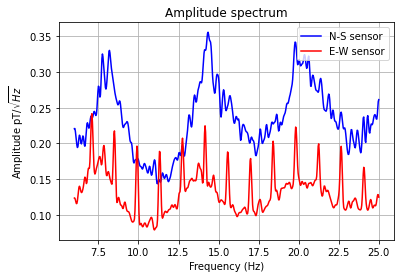

In [8]:
i=5
nho=0
ndi=1
indi=i+nho*6+ndi*24
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Amplitude pT/$\sqrt{Hz}$')
plt.title('Amplitude spectrum')
plt.plot(fre,medidas0[indi,:],c='b',label='N-S sensor')
plt.plot(fre,medidas1[indi,:],c='r',label='E-W sensor')
plt.legend(loc=1)
#plt.savefig('Fig2.eps')
plt.show()

In [9]:
def spectrumNoisy(i,nho,ndi):
    indi=i+nho*6+ndi*24
    plt.grid()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Amplitude pT/$\sqrt{Hz}$')
    plt.title('Amplitude spectrum')
    plt.plot(fre,medidas0[indi,:],c='b',label='N-S sensor')
    plt.plot(fre,medidas1[indi,:],c='r',label='E-W sensor')
    plt.legend(loc=1)
    plt.show()

In [10]:
interact(spectrumNoisy,i=(0,6-1),nho=(0,23),ndi=(0,ndias-1))

interactive(children=(IntSlider(value=2, description='i', max=5), IntSlider(value=11, description='nho', max=2…

<function __main__.spectrumNoisy(i, nho, ndi)>

With the function `interact` from ipywidgets package and the `spectrumNoisy` function, we can display the spectrum, for both sensors and for each 10-minute interval of the month that we are analyzing.

This visualization allows defining the anthropogenic and reference noise bands discussed below.

## Anthropogenic noise and reference frequency bands

In [11]:
listafrecantro=np.array([[[14.55,14.90],[14.1,14.5]],\
                         [[14.90,15.35],[15.5,15.8]],\
                         [[16.50,16.90],[15.8,16.4]]])
positions=np.array([pofre(f,df,bandcal[0])\
                   for f in listafrecantro.ravel()],dtype=int)
antropos=(positions.reshape(listafrecantro.shape))[:,0]
refepos=(positions.reshape(listafrecantro.shape))[:,1]

At this point the frequency bands with anthropogenic noise are defined. For each one, we must also define a reference band that is free of anthropogenic noise and with similar characteristics to that containing the noise.

These bands are valid for all months, although in specific cases the starting and ending points must slightly be modified. There are two types of antropoghenic noise: one that has been associated with the electric generator of the mountain hut near the station and another one that seems to be associated with the Central Europe railway network. The first noise sometimes presents two peaks with very close frequencies, so it is necessary to associate two contiguous bands of anthropogenic noise.

Using the `pofre` function, the positions in the calibration band corresponding to boundary frequencies that appear for both the noise and reference bands are located.

## Filtering functions

In [12]:
def recta(val,frec):
    a=(val[-1]-val[0])/(frec[-1]-frec[0])
    b=val[0]
    valmod=a*(frec-frec[0])+b
    de=np.max((val-valmod)/valmod)+np.min((val-valmod)/valmod)
    pmax=np.where(val==np.max(val))[0][0]
    return valmod, de, [frec[pmax],val[pmax],valmod[pmax]]

Given a set of amplitude spectrum values, `val`, and its frequencies `frec`, the function `recta` calculates:
- the parameters (slope and intercept) of the line defined by the first and last values in `val` and `frec` and with these parameters calculates the value of the line corresponding to each frequency in `frec`. 
- the relative difference (with respect to the value of the line) between the points of the line and the values for each frequency; the maximum and minimum values of these relative differences are found and added up to give a value that we will name the filter trigger value.
- the position of the maximun value in the list `val`; a list with frequency, value and line value at this position in each corresponding list is formed.


In [13]:
def antro(medidasantro,fre,refpos,antropos,satper,facfil):
    antrolis=[]
    medidas=np.copy(medidasantro)
    for i in range(len(medidas)):
        if satper[i]<0.9999:
            cont=0
            for j in range(len(antropos)):
                desvia = recta(medidas[i,refpos[j,0]:refpos[j,1]+1],\
                               fre[refpos[j,0]:refpos[j,1]+1])[1]
                resul = recta(medidas[i,antropos[j,0]:antropos[j,1]+1],\
                              fre[antropos[j,0]:antropos[j,1]+1])
                if(resul[1]>facfil*np.abs(desvia)):
                    cont=cont+1
                    medidas[i,antropos[j,0]:antropos[j,1]+1]=resul[0]
                    antrolis.append([i,*resul[2]])
                if(cont==2 and j==1):
                    resul = recta(medidas[i,antropos[0,0]:antropos[1,1]+1],\
                                  fre[antropos[0,0]:antropos[1,1]+1])
                    medidas[i,antropos[0,0]:antropos[1,1]+1]=resul[0]
        else:
            print("Saturated interval ",i)  
    return medidas, antrolis

In [14]:
medcor0,antrolis0 = antro(medidas0,fre,refepos,antropos,satper0,2.5)
medcor1,antrolis1 = antro(medidas1,fre,refepos,antropos,satper1,2.5)
varsal=1

The `antro` function performs noise correction for the entire month. It starts with a loop that goes through all the 10-minute intervals in the month, `{i, 1, Length [medidas]}`. This is followed by another loop for the entire list of bands with possible anthropogenic noise and reference bands, `{j, 1, Length [anthropos]}`. For each interval and each band the following sentences are executed:
* For the reference band, the filter reference trigger value is determined with the function `recta` and it is stored in `desvia`. Therefore, a single value is used from the output of the `recta` function.
* For the anthropogenic band, the function `recta` gives the following output: the line values, the filter noise trigger value and the list associated with the maximum amplitude reached by the anthropogenic noise: frequency, measurement value and fitting curve value.
* The filter operates on the condition that the filter noise trigger value is greater than the filter reference trigger value multiplied by a factor defined by the last argument of the `antro` function. If the filter is trigged, the measurements are modified with the straight line and the information corresponding to that antropogenic noise band and the 10 min interval is added to the list `antrolis`.
* If the filter acts in the first two bands (the noise of the electrical generator has two peaks) then with the function `recta` a new line is drawn for the band defined by the union of the two bands with the anthropogenic noise of the electrical generator. With this, the conflict generated by the union area of both bands is avoided. This is why it is important to keep the same value for the end and the beginning of each band.
* Finally, the filtered values of the measurements and the list with the anthropogenic noise information are exported from the function.

In the current form of code, the list `antrolis`, containing anthropogenic noise information, is not written to any file. Using this information, it would be possible to carry out a study on the characteristics of the anthropogenic noise that appeared at the ELF station in Sierra Nevada, which is yet to be done.

## Filtering review

In the last line of code of the previous block, the variable `valsal` is defined with the value 1 indicating that the filter has been applied once.
There are intervals in which the anthropogenic noise associated with the electric generator has a greater bandwidth than usual. In these cases, the filter must be reapplied in a band of anthropogenic noise that contains the first two bands defined in the first application of the filter.

In [15]:
def spectrumDeNoisy(i,nho,ndi):
    indi=i+nho*6+ndi*24
    plt.grid()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Amplitude pT/$\sqrt{Hz}$')
    plt.title('Amplitude spectrum')
    plt.plot(fre,medcor0[indi,:],c='b',label='N-S sensor')
    plt.plot(fre,medcor1[indi,:],c='r',label='E-W sensor')
    plt.legend(loc=1)
    plt.show()

In [16]:
interact(spectrumDeNoisy,i=(0,6-1),nho=(0,23),ndi=(0,ndias-1))

interactive(children=(IntSlider(value=2, description='i', max=5), IntSlider(value=11, description='nho', max=2…

<function __main__.spectrumDeNoisy(i, nho, ndi)>

To determine if the filter needs to be applied again, a new function, `spectrumDeNoisy` is defined to display the filtered spectra. The definition is analogous to `spectrumNoisy` but the filtered spectra are represented now. The `interact` application from the` ipywidgets` package continues to be used.

In [17]:
listafrecantroRe=np.array([[[14.55,15.35],[13.5,13.9]]])
positionsRe=np.array([pofre(f,df,bandcal[0])\
                   for f in listafrecantroRe.ravel()],dtype=int)
antroposRe=(positionsRe.reshape(listafrecantroRe.shape))[:,0]
refeposRe=(positionsRe.reshape(listafrecantroRe.shape))[:,1]

As mentioned above, the second application of the filter is done considering an antropogenic noice band that encompasses the two peaks of the electric generator noise. In the third antropogenic noice band, caused probably by the Central Europe railway network, no problem has been detected for now when the filter is firstly applied, and then this band is not included in the second filtering action.

In [18]:
medcor0Re,antrolis0Re = antro(medcor0,fre,refeposRe,antroposRe,satper0,3)
medcor1Re,antrolis1Re = antro(medcor1,fre,refeposRe,antroposRe,satper1,3)
varsal=2

A new call is made for each sensor to the function `antro`, which applies the filter again, with the new anthropogenic noice band. The variable `versal` indicates that the filter has been passed a second time.

In [19]:
def spectrumDeNoisyAgain(i,nho,ndi):
    indi=i+nho*6+ndi*24
    plt.grid()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Amplitude pT/$\sqrt{Hz}$')
    plt.title('Amplitude spectrum')
    plt.plot(fre,medcor0Re[indi,:],c='b',label='N-S sensor')
    plt.plot(fre,medcor1Re[indi,:],c='r',label='E-W sensor')
    plt.legend(loc=1)
    plt.show()

In [20]:
interact(spectrumDeNoisyAgain,i=(0,6-1),nho=(0,23),ndi=(0,ndias-1))

interactive(children=(IntSlider(value=2, description='i', max=5), IntSlider(value=11, description='nho', max=2…

<function __main__.spectrumDeNoisyAgain(i, nho, ndi)>

We make a new viewing of the spectra that must be free of anthropogenic noise.

La celda siguiente es para generar gráficas de espectros con y sin ruido antropogénico en determinados intervalos temporales de 10 min.

The next cell is for generating spectra figuress with and without anthropogenic noise at specified 10 min time intervals.

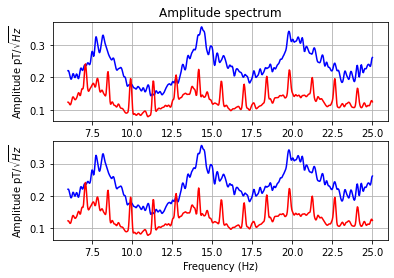

In [22]:
i=5
nho=0
ndi=1
indi=i+nho*6+ndi*24

# Create two subplots sharing y axis
fig, (ax1, ax2) = plt.subplots(2,1)
plt.grid()
ax1.plot(fre,medidas0[indi,:],c='b',label='N-S sensor')
ax1.plot(fre,medidas1[indi,:],c='r',label='E-W sensor')
ax1.set(title='Amplitude spectrum', ylabel=r'Amplitude pT/$\sqrt{Hz}$')
ax1.grid()
ax2.plot(fre,medcor0Re[indi,:],c='b',label='N-S sensor')
ax2.plot(fre,medcor1Re[indi,:],c='r',label='E-W sensor')
ax2.set(xlabel='Frequency (Hz)', ylabel=r'Amplitude pT/$\sqrt{Hz}$')
#plt.savefig('Fig3.eps')
plt.show()


## Output

The names of the output files are defined with the new infix `mediaNA`.

Depending on the value of the variable `varsal`, which controls whether the filter has been applied a second time, the variable with the corresponding spectra is written in the output file.

In [23]:
fichsal0=open(pathmes+"mediaNA"+"_0",mode='w')
fichsal1=open(pathmes+"mediaNA"+"_1",mode='w')

if varsal==1:
    print(*medcor0.ravel(),sep='\n',file=fichsal0)
    print(*medcor1.ravel(),sep='\n',file=fichsal1)
elif varsal==2:
    print(*medcor0Re.ravel(),sep='\n',file=fichsal0)
    print(*medcor1Re.ravel(),sep='\n',file=fichsal1)
else:
    print('Wrong output value')

fichsal0.close()
fichsal1.close()